In [1]:
import pickle
import os
import io
import re
import networkx as nx
import netwulf as nw 
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
def setup_mpl():
    mpl.rcParams['font.family'] = 'Times New Roman'
    mpl.rcParams['lines.linewidth'] = 2
    return
setup_mpl()

In [3]:
import os

In [4]:
df_marvel = pd.read_csv("../files/marvel.csv", index_col=0, encoding='utf8')
df_marvel = df_marvel[df_marvel["WikiLink"].notna()]
df_dc = pd.read_csv("../files/dc.csv", index_col=0, encoding='utf8')
df_dc = df_dc[df_dc["WikiLink"].notna()]
df_marvel['universe'] = 'Marvel'
df_dc['universe'] = 'DC'
df = pd.concat([df_marvel, df_dc], ignore_index=True, axis=0)
edgelist = pd.read_csv("../corrected_edgelist.csv")
edgelist = edgelist.drop_duplicates(ignore_index=True)

In [5]:
def ensemble_louvain(graph, N, k, threshold = 0.9):
    ''' The same algorithm is used with Infomap later!
    1) run several trials of Louvain on the same network,
    2) built a new network where a pair of the original nodes is linked if their total co-membership across all the Louvain trials is above a given threshold (e.g., 90%),
    3) identify the disjoints sets which represent the resulting communities.'''
    from community import community_louvain 
    import random
    from collections import Counter
    from collections import defaultdict
    import string
    from itertools import combinations
    from tqdm import tqdm
    
    #step 1
    tot_communities = []
    for iter_ in tqdm(range(N), disable=True):
        
        partition = community_louvain.best_partition(graph)
        tot_communities.append(partition)
    
    #step 2
    G_new = nx.Graph() #Don't think this has to be directed
    node_pairs = combinations(list(graph.nodes), 2)
    for (u,v) in tqdm(node_pairs, disable=True):
        co_occurence = 0
        for partitions in tot_communities:
            if partitions[u] == partitions[v]: 
                co_occurence += 1
        if co_occurence/N > threshold:
            G_new.add_edge(u, v)
        
        
    #step 3
    k_greatest_components = {i: list(community) for i, community in enumerate(sorted(nx.connected_components(G_new), key=len, reverse=True)[:k])}
    
    
    return k_greatest_components

In [6]:
graphs = {}
for key in np.arange(2001,2023,1):
    graphs[key] = nx.read_gml(f'../graphs/DG_{key}')

In [7]:
import matplotlib.cm as cm
import networkx as nx

G = graphs[2022].copy().to_undirected()

# split into marvel and DC
marvel = []
dc = []
for key, value in nx.get_node_attributes(G,'Universe').items():
    if value == 'Marvel':
        marvel.append(key)
    elif value == 'DC':
        dc.append(key)

G_marvel = G.subgraph(marvel)
G_dc = G.subgraph(dc)

#Keep only largest component
G_marvel = G_marvel.subgraph(sorted(nx.connected_components(G_marvel), key=len, reverse=True)[0])
G_dc = G_dc.subgraph(sorted(nx.connected_components(G_dc), key=len, reverse=True)[0])

# compute the best partition
k = 10 #N communities in each subgraph!
partition_marvel = ensemble_louvain(G_marvel,100,k)
partition_marvel = {value[i]: key for key, value in partition_marvel.items() for i in range(len(value))}
partition_dc = ensemble_louvain(G_dc,100,k)
partition_dc = {value[i]: key for key, value in partition_dc.items() for i in range(len(value))}
n_marvel_communities = np.unique(list(partition_marvel.values()))
n_dc_communities = np.unique(list(partition_dc.values()))


dc_pss = {}
marvel_pss = {}
for key in graphs.keys():
    dc_ps = []
    marvel_ps = []
    for node in graphs[key].nodes():
        try:
            graphs[key-1].nodes()[node]
            continue
        except:
            pass
        try:
            p_number_marvel = partition_marvel[node]
            marvel_ps.append(p_number_marvel)
        except:
            try:
                p_number_dc = partition_dc[node]
                dc_ps.append(p_number_dc)
            except:
                continue
    dc_pss[key] = dc_ps
    marvel_pss[key] = marvel_ps

from collections import Counter

dc_counts = {}
for key, value in dc_pss.items():
    dc_counts[key] = Counter(value)
marvel_counts = {}
for key, value in marvel_pss.items():
    marvel_counts[key] = Counter(value)

In [8]:
#number of communities shown
n_communities=k*2

In [9]:
partition_matrix = np.zeros((n_communities,22))
count = 0
for key, value in dc_counts.items():
    for key2, value2 in value.items():
        partition_matrix[key2+k,count] = value2
    count += 1
count = 0
for key, value in marvel_counts.items():
    for key2, value2 in value.items():
        partition_matrix[key2,count] = value2
    count += 1

In [10]:
marvel = partition_matrix[:k, :]
marvel.shape

(10, 22)

In [11]:
DC = partition_matrix[k:, :]
DC.shape

(10, 22)

In [12]:
import matplotlib.gridspec as grid_spec
from matplotlib.pyplot import cm
from tqdm.notebook import tqdm

def ridge_plot(df, categories, group, y, title, step=1, hspace=0.5, agg=False, figsize=(20,10),
              cumulative=False):
    #determing xlim and ylim
    xmax = df[y].values.max()
    
    temp = df[y].values
    
    if agg:
        step = max(int(len(np.unique(temp))/20), 1)

    bins = np.arange(min(temp), max(temp), step)
    hist, edges = np.histogram(temp, bins=bins, density=True)
    ymax = np.histogram(temp, bins=bins, density=True)[0].max()
    
    n = len(categories)
    #cmap = cm.set2(np.linspace(0, 1, 2))
    colors = cm.rainbow(np.linspace(0, 1, n))
    gs = grid_spec.GridSpec(n,1)
    fig = plt.figure(figsize=figsize, dpi=100)
    ax_objs = []

    
    for i, category in tqdm(enumerate(categories)):
        temp_corpus = df[df[group]==category]
        metric = list(temp_corpus[y].values)
        
            
        if agg:
            step = max(int(len(np.unique(metric))/20), 1)
        
        bins = np.arange(min(metric), max(metric), step)
        hist, edges = np.histogram(metric, bins=bins, density=True)
        x = (edges[1:] + edges[:-1])/2
        width = bins[1]-bins[0]

        # creating new axes object
        ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

        # plotting the distribution
        if cumulative:
            hist = np.cumsum(hist)
            ax_objs[-1].bar(x, hist, width=width*0.90, color=colors[i], alpha=0.95)
            #ax_objs[-1].plot(x, hist, color=colors[i], alpha=0.95)
            #ax_objs[-1].hist(metric, bins, density=True,
            #               cumulative=True, histtype='step', color=colors[i], alpha=0.80)
        else:
            ax_objs[-1].bar(x, hist, width=width*0.90, color=colors[i], alpha=0.95)
        #Might be an issue here
        # setting uniform x and y lims
        ax_objs[-1].set_xlim(0,xmax)
        ax_objs[-1].set_ylim(0,ymax + 1e-2)

        # make background transparent
        rect = ax_objs[-1].patch
        rect.set_alpha(0)

        # remove borders, axis ticks, and labels
        ax_objs[-1].set_yticklabels([])

        # remove xticks labels
        if i != len(categories) - 1:
            ax_objs[-1].set_xticklabels([])
        else:
            ax_objs[-1].set_xlabel(f'{y}')

        # remove xticks
        ax_objs[-1].tick_params(axis=u'both', which=u'both',length=0)

        spines = ["top","right","left","bottom"]
        for s in spines:
            ax_objs[-1].spines[s].set_visible(False)

        ax_objs[-1].text(-0.10,0.0, category,fontweight="bold",fontsize=14,ha="right")



    gs.update(hspace=-hspace)

    fig.text(0.07,0.90, title,fontsize=20)
    
    #plt.savefig('ridgeplot_test.png')
    #plt.savefig('ridgeplot_test.png',bbox_inches='tight')
    plt.show()
    return None

In [13]:
values = partition_matrix.flatten()

In [14]:
universe = ['Marvel' if i < values.shape[0]/2 else 'DC' for i in range(values.shape[0])]
unique_years = [2001 + i for i in range(2023-2001)]
years = [item for sublist in [[year]*10 for year in unique_years] for item in sublist]
years.extend(years)
communities = []
for _ in range(len(unique_years)):
    communities.append([i for i in range(1,11)])
communities = [item for sublist in communities for item in sublist]
communities.extend(communities)

In [15]:
values.shape, len(universe), len(years), len(communities)

((440,), 440, 440, 440)

In [16]:
burst_df = pd.DataFrame({'value':values, 'Universe':universe, 'year':years, 'communities':communities})

In [17]:
burst_df

,value,Universe,year,communities
0,0.0,Marvel,2001,1
1,6.0,Marvel,2001,2
2,42.0,Marvel,2001,3
3,50.0,Marvel,2001,4
4,80.0,Marvel,2001,5
...,...,...,...,...
435,0.0,DC,2022,6
436,0.0,DC,2022,7
437,0.0,DC,2022,8
438,0.0,DC,2022,9


0it [00:00, ?it/s]

0it [00:00, ?it/s]

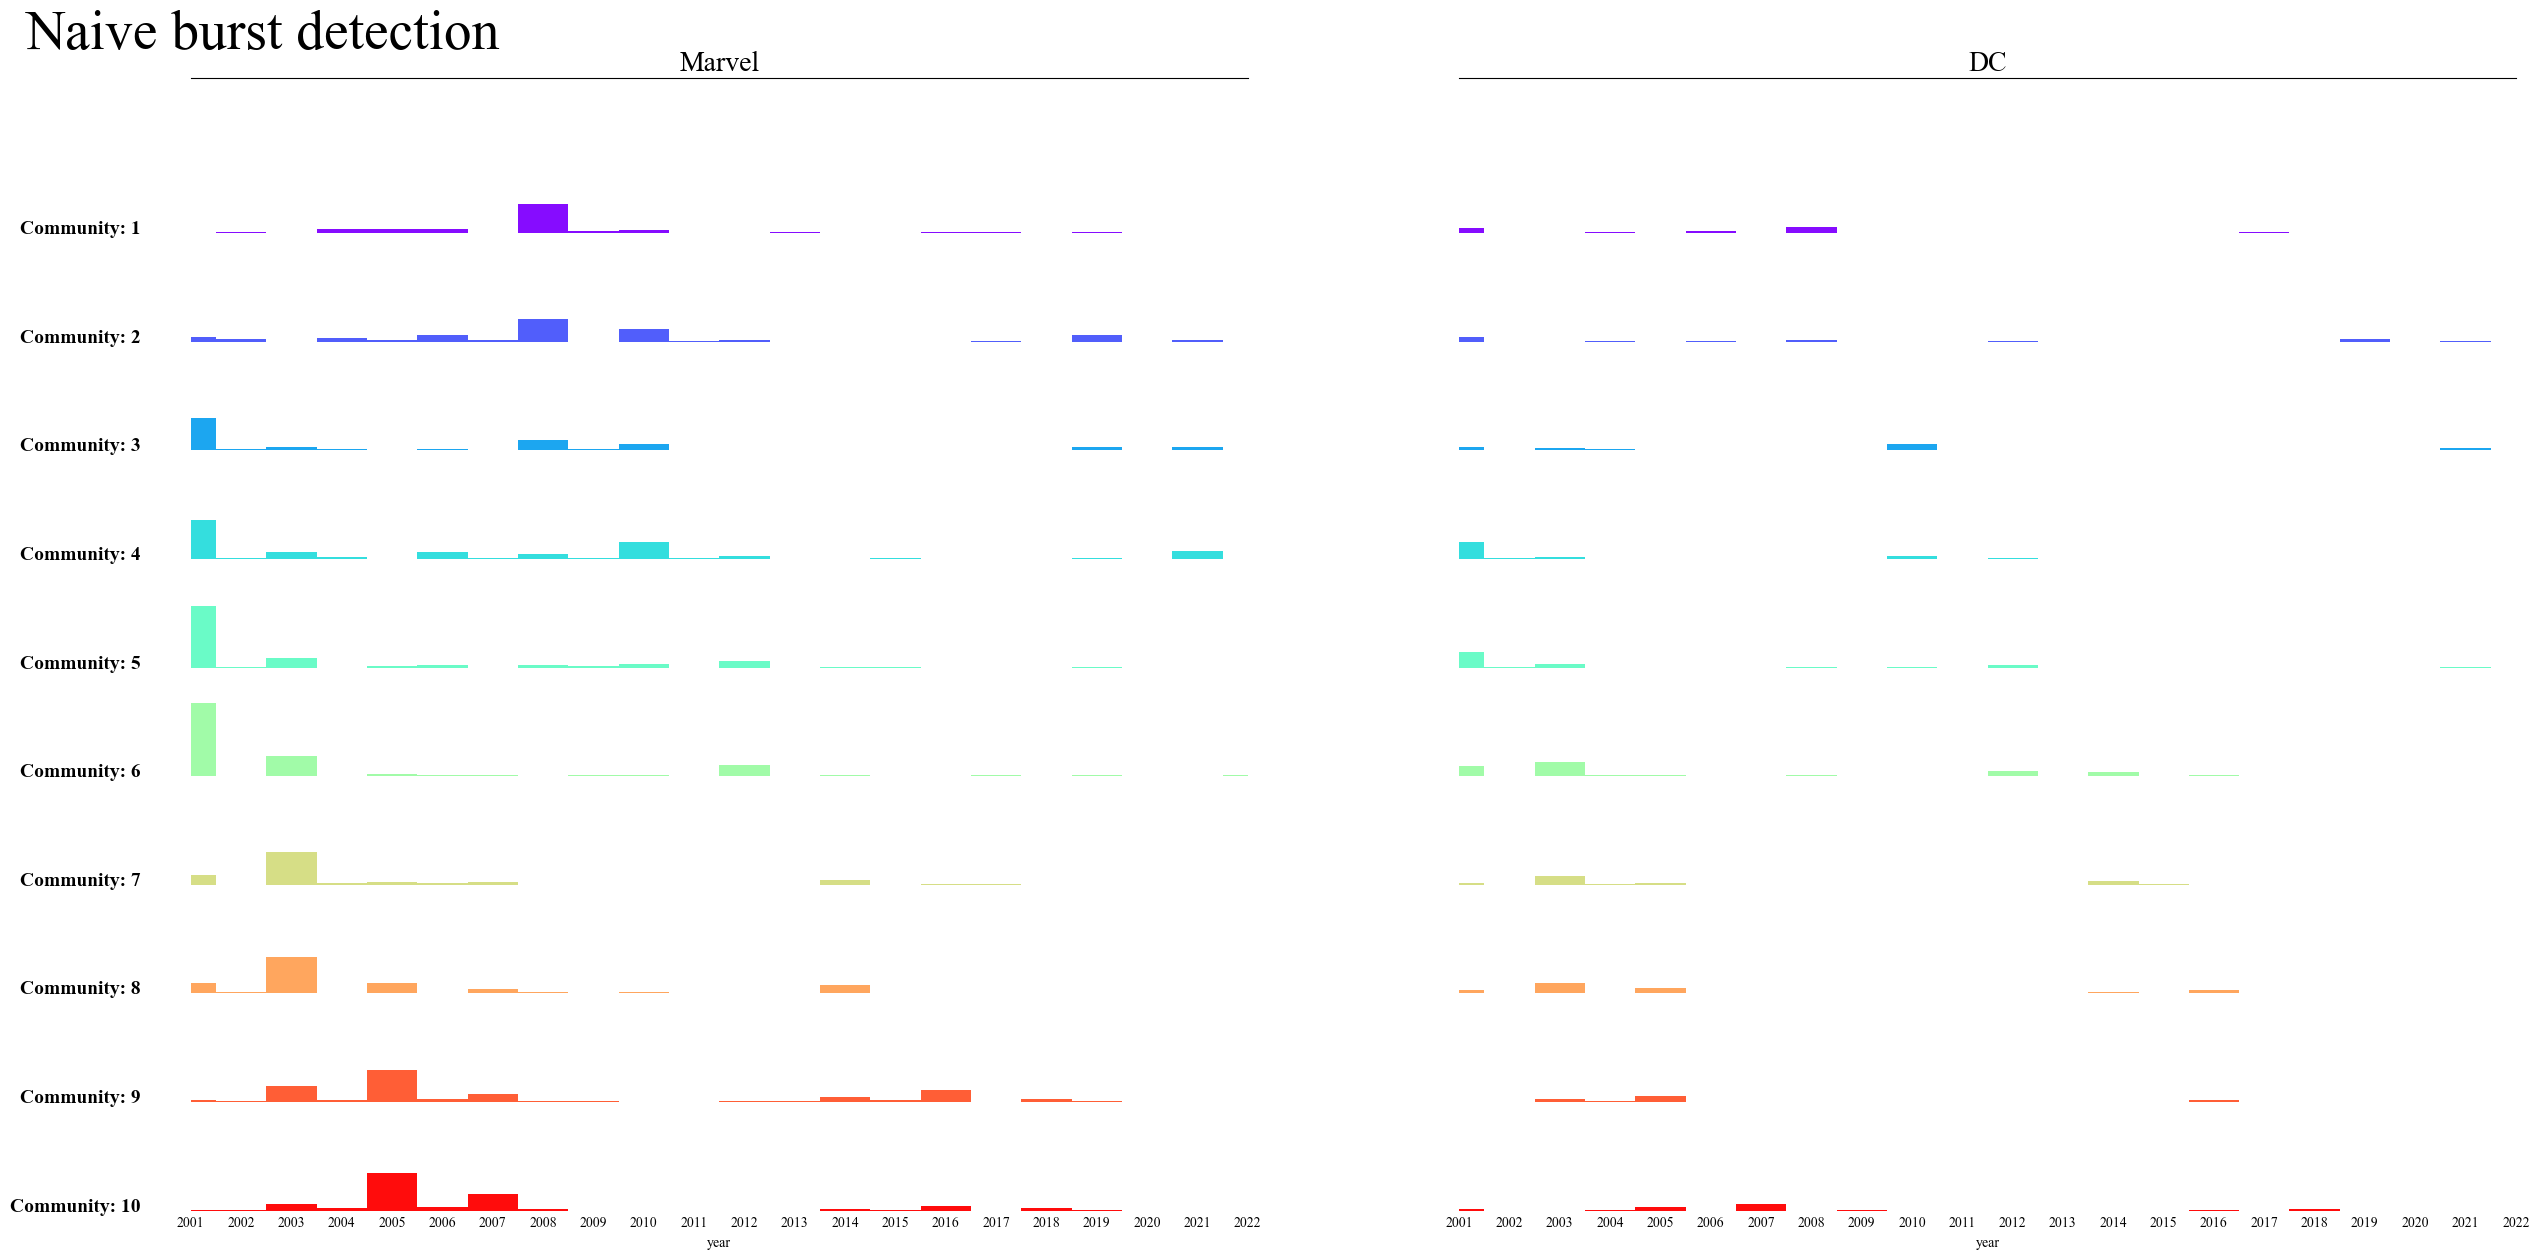

In [18]:

title = "Naive burst detection"
step=1
hspace=0.3
agg=False
figsize=(30,15)
cumulative=False

categories = burst_df.communities.sort_values().unique()
group = 'communities'

y = 'value'
df = burst_df


temp = df[y].values

if agg:
    step = max(int(len(np.unique(temp))/20), 1)

bins = np.arange(min(temp), max(temp), step)
hist, edges = np.histogram(temp, bins=bins, density=True)
ymax = np.histogram(temp, bins=bins, density=True)[0].max()

n = len(categories)
#cmap = cm.set2(np.linspace(0, 1, 2))
colors = cm.rainbow(np.linspace(0, 1, n))
fig = plt.figure(figsize=figsize, dpi=100)
gs = grid_spec.GridSpec(n,2)
ax_objs = []


for j, universe in enumerate(['Marvel', 'DC']):
    for i, category in tqdm(enumerate(categories)):
        mask = ((df[group]==category) & (df['Universe']==universe))
        temp_corpus = df[mask]
        metric = list(temp_corpus[y].values)
        years = list(temp_corpus['year'].values)
        
        # creating new axes object
        ax_objs.append(fig.add_subplot(gs[i:i+1, j:j+1]))
        # plotting the distribution
        if cumulative:
            hist = np.cumsum(hist)
            ax_objs[-1].bar(years, metric, color=colors[i], alpha=0.95)
            #ax_objs[-1].plot(x, hist, color=colors[i], alpha=0.95)
            #ax_objs[-1].hist(metric, bins, density=True,
            #               cumulative=True, histtype='step', color=colors[i], alpha=0.80)
        else:
            ax_objs[-1].bar(years, metric, width=1, color=colors[i], alpha=0.95)
        #Might be an issue here
        # setting uniform x and y lims
        ax_objs[-1].set_xlim(2001, 2022)
        ax_objs[-1].set_ylim(0, 200)

        # make background transparent
        rect = ax_objs[-1].patch
        rect.set_alpha(0)

        # remove borders, axis ticks, and labels
        ax_objs[-1].set_yticklabels([])

        # remove xticks labels
        if i != len(categories) - 1:
            ax_objs[-1].set_xticklabels([])
        else:
            ax_objs[-1].set_xlabel('year')
            ax_objs[-1].set_xticks(unique_years)
        if i == 0:
            ax_objs[-1].set_title(f'{universe}', fontsize=20)
        # remove xticks
        ax_objs[-1].tick_params(axis=u'both', which=u'both',length=0)

        spines = ["top","right","left","bottom"]
        for s in spines:
            ax_objs[-1].spines[s].set_visible(False)

        if i == 0:
            ax_objs[-1].spines['top'].set_visible(True)


        if universe == 'Marvel':
            ax_objs[-1].text(2000, 0.0, f'Community: {category}', fontweight="bold",fontsize=14,ha="right")


gs.update(hspace=-hspace)

fig.text(0.07,0.90, title,fontsize=40)

#plt.savefig('ridgeplot_test.png')
#plt.savefig('ridgeplot_test.png',bbox_inches='tight')
plt.show()

Using kernel density for ridge plots

In [19]:
from sklearn.neighbors import KernelDensity
import seaborn as sns
from scipy.stats import gaussian_kde

0it [00:00, ?it/s]

0it [00:00, ?it/s]

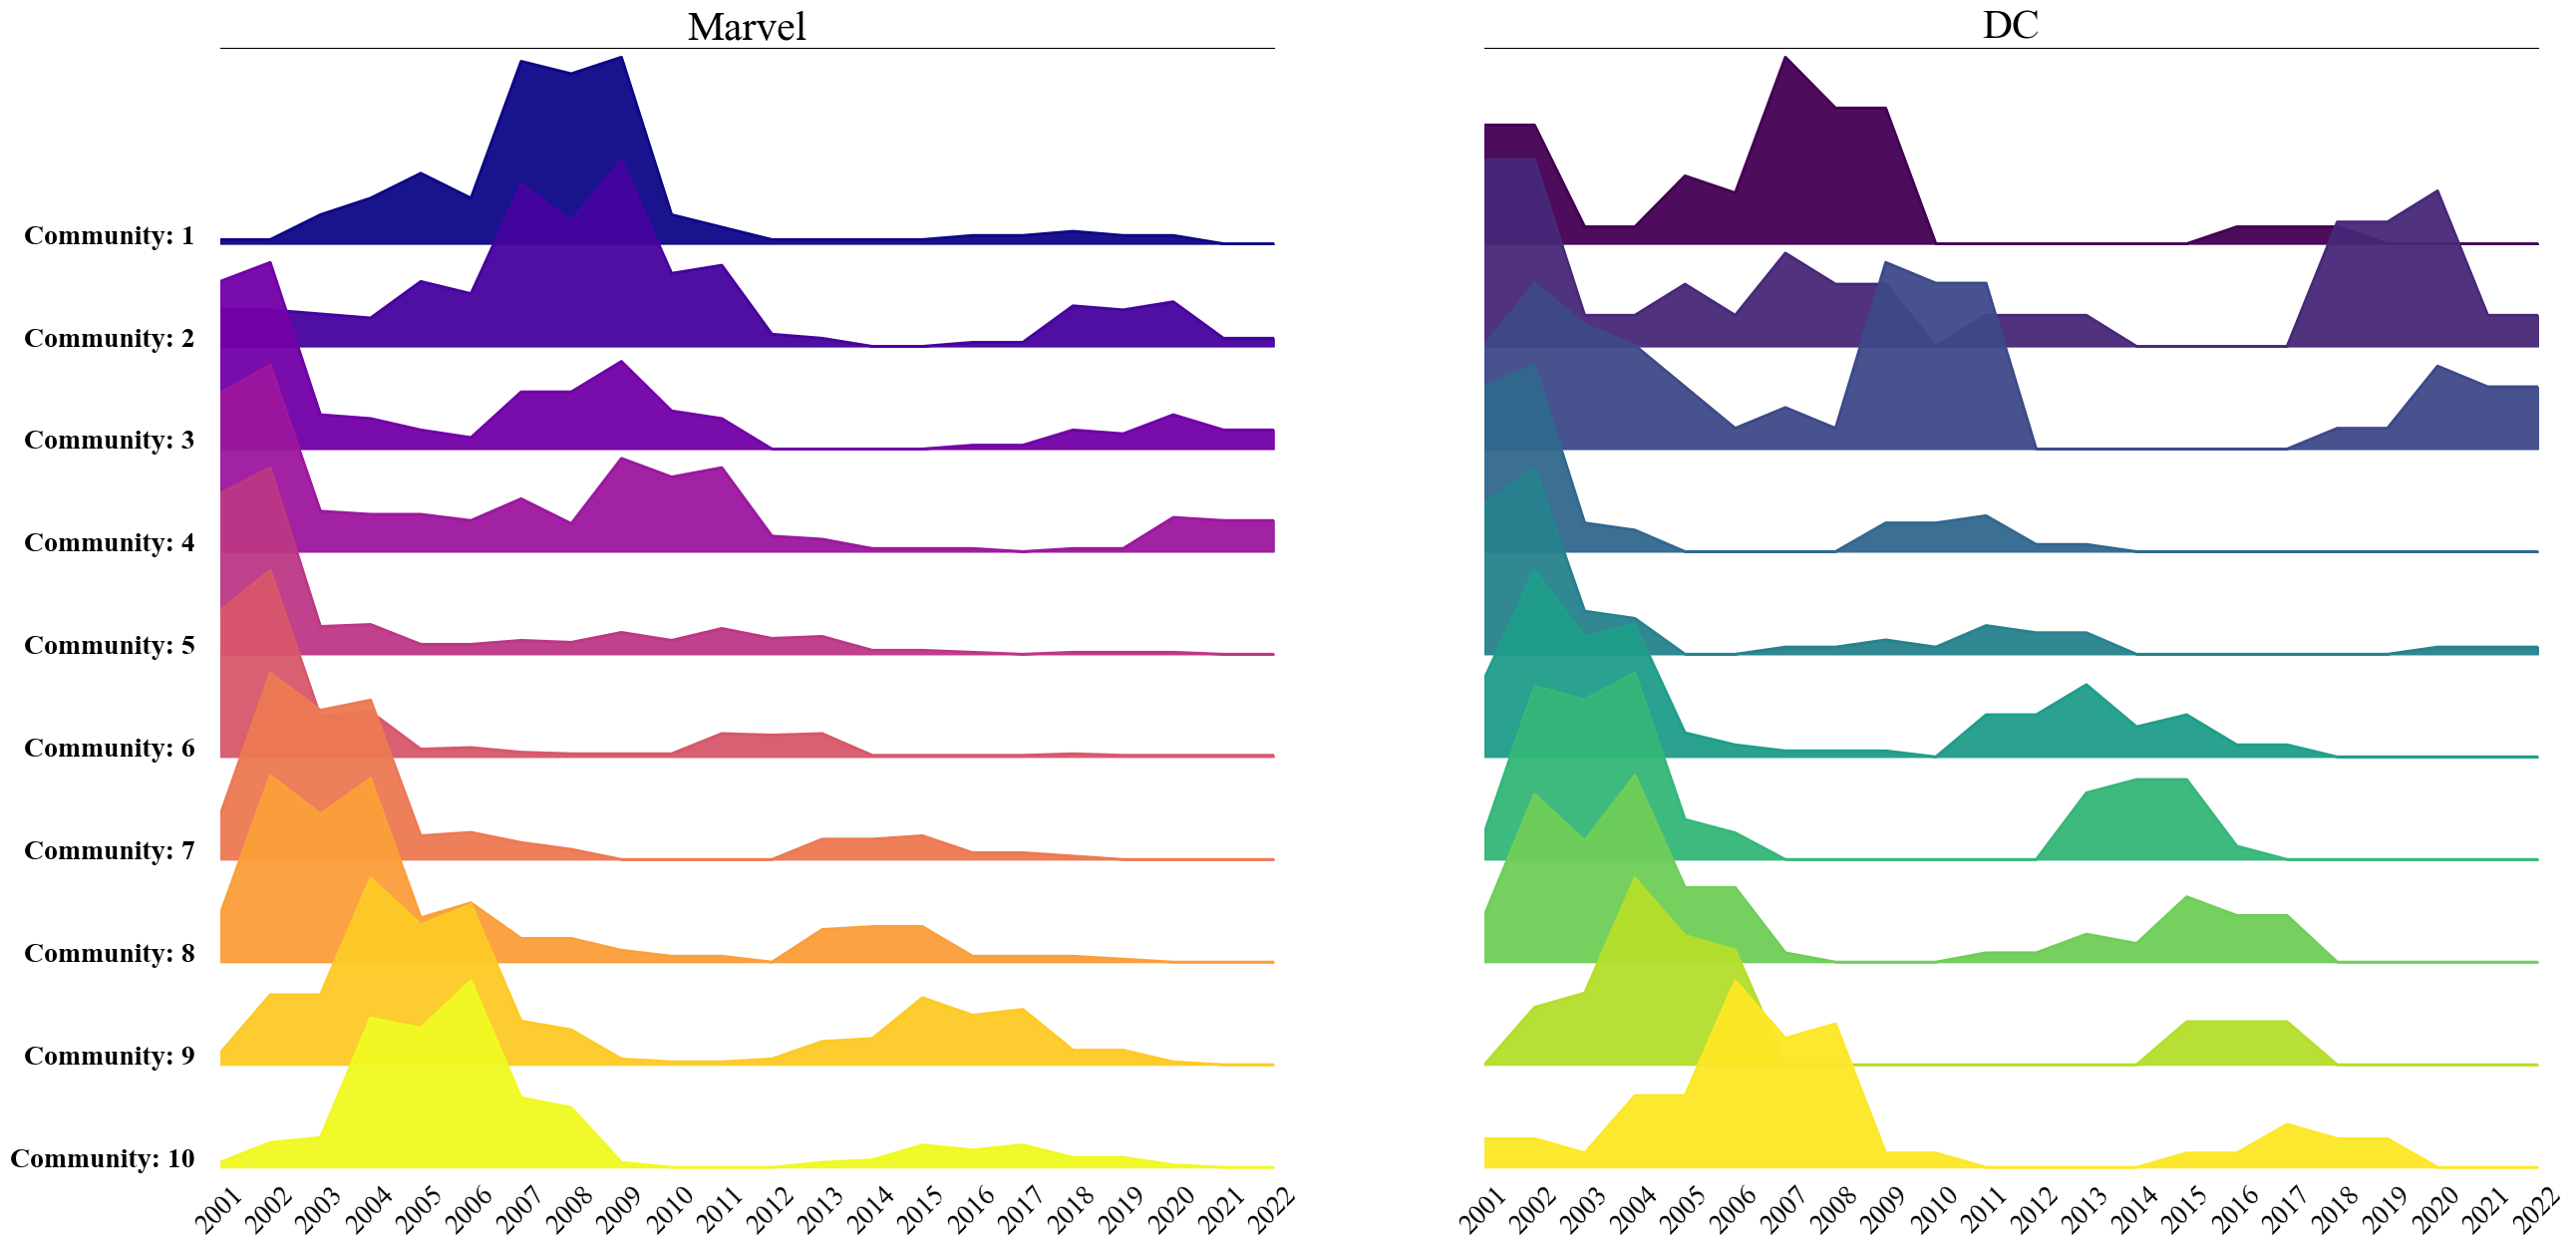

In [47]:
title = "Naive Burst Detection"
step=1
hspace=0.5
agg=False
figsize=(30,15)
cumulative=False

categories = burst_df.communities.sort_values().unique()
group = 'communities'

y = 'value'
df = burst_df


temp = df[y].values

#if agg:
#    step = max(int(len(np.unique(temp))/20), 1)

#bins = np.arange(min(temp), max(temp), step)
#hist, edges = np.histogram(temp, bins=bins, density=True)
#ymax = np.histogram(temp, bins=bins, density=True)[0].max()

n = len(categories)
#cmap = cm.set2(np.linspace(0, 1, 2))
colors = [cm.plasma(np.linspace(0, 1, n)), cm.viridis(np.linspace(0, 1, n))]
fig = plt.figure(figsize=figsize, dpi=100)
gs = grid_spec.GridSpec(n,2)
ax_objs = []


for j, universe in enumerate(['Marvel', 'DC']):
    for i, category in tqdm(enumerate(categories)):
        mask = ((df[group]==category) & (df['Universe']==universe))
        temp_corpus = df[mask]
        metric = list(temp_corpus[y].values)
        years = list(temp_corpus['year'].values)
        
        # creating new axes object
        ax_objs.append(fig.add_subplot(gs[i:i+1, j:j+1]))
        # plotting the distribution
        if cumulative:
            hist = np.cumsum(hist)
            ax_objs[-1].bar(years, metric, color=colors[j][i], alpha=0.95)
            #ax_objs[-1].plot(x, hist, color=colors[i], alpha=0.95)
            #ax_objs[-1].hist(metric, bins, density=True,
            #               cumulative=True, histtype='step', color=colors[i], alpha=0.80)
        else:
            #ax_objs[-1].bar(years, metric, width=1, color=colors[i], alpha=0.95)
            N = 3
            L_point_MA = np.convolve(metric, np.ones(N)/N, mode='same')
            ax_objs[-1].plot(years, L_point_MA, color=colors[j][i])
            ax_objs[-1].fill_between(years, L_point_MA, alpha=0.95,color=colors[j][i])
            #ax_objs[-1] = sns.kdeplot(np.array(metric), color=colors[i], fill=True)
            
            #Kernel desnsity estimate
            #density = gaussian_kde(metric)
            #xs =  np.linspace(1,23,00) #np.array(unique_years)
            #xs = np.array(unique_years)
            #density.covariance_factor = lambda : .25
            #density._compute_covariance()
            #ax_objs[-1].plot(xs,density(xs), color=colors[i])
            #ax_objs[-1].fill_between(xs, density(xs), alpha=1,color=colors[i])

            #x_d = np.linspace(1,23, 100)

            #kde = KernelDensity(bandwidth=0.03, kernel='gaussian')
            #kde.fit(np.array(metric).reshape(-1, 1))

            #logprob = kde.score_samples(x_d[:, None])

            # creating new axes object
            #ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

            # plotting the distribution
            #ax_objs[-1].plot(x_d, np.exp(logprob),color="#f0f0f0",lw=1)
            #ax_objs[-1].fill_between(x_d, np.exp(logprob), alpha=1,color=colors[i])
        #Might be an issue here
        # setting uniform x and y lims
        ax_objs[-1].set_xlim(2001, 2022)
        #ax_objs[-1].set_ylim(0, 200)

        # make background transparent
        rect = ax_objs[-1].patch
        rect.set_alpha(0)

        # remove borders, axis ticks, and labels
        ax_objs[-1].set_yticklabels([])

        # remove xticks labels
        if i != len(categories) - 1:
            ax_objs[-1].set_xticklabels([])
        else:
            #ax_objs[-1].set_xlabel('year')
            ax_objs[-1].set_xticks(unique_years)
            ax_objs[-1].tick_params(axis='both', which='major', labelsize=20, rotation=45)
        if i == 0:
            ax_objs[-1].set_title(f'{universe}', fontsize=30)
        # remove xticks
        ax_objs[-1].tick_params(axis=u'both', which=u'both',length=0)

        spines = ["top","right","left","bottom"]
        for s in spines:
            ax_objs[-1].spines[s].set_visible(False)

        if i == 0:
            ax_objs[-1].spines['top'].set_visible(True)


        if universe == 'Marvel':
            ax_objs[-1].text(2000.5, 0.0, f'Community: {category}', fontweight="bold",fontsize=20,ha="right")


gs.update(hspace=-hspace)

#fig.text(0.07,0.90, title,fontsize=40)

#plt.savefig('ridgeplot_test.png')
plt.savefig('ridgeplot_naive_burst.png',bbox_inches='tight')
plt.show()

It seems that the kernel estimate only notice the initial period of the network evolution where the number of revisions experience cubic growth. Let us try to exclude this part and examine the rest of the network evolution:

# Evolving communities

In [49]:
import random
import plotly.express as px
from infomap import Infomap
import plotly.graph_objects as go
from collections import Counter
from collections import defaultdict
import string
import networkx as nx
import numpy as np
from tqdm import tqdm
from itertools import combinations
import os
import pandas as pd

In [50]:

#Getting data
df_marvel = pd.read_csv("../files/marvel.csv", index_col=0, encoding='utf8')
df_marvel = df_marvel[df_marvel["WikiLink"].notna()]
df_dc = pd.read_csv("../files/dc.csv", index_col=0, encoding='utf8')
df_dc = df_dc[df_dc["WikiLink"].notna()]
df_marvel['universe'] = 'Marvel'
df_dc['universe'] = 'DC'
df = pd.concat([df_marvel, df_dc], ignore_index=True, axis=0)

edgelist = pd.read_csv("../corrected_edgelist.csv")
temp = pd.merge(edgelist, df, left_on='source', right_on='WikiLink')
temp = temp.rename(columns={"universe":"source universe"})
temp = temp.drop(columns=['CharacterName', 'WikiLink'])
temp = pd.merge(temp, df, left_on='target', right_on='WikiLink')
temp = temp.rename(columns={"universe":"target universe"})
temp = temp.drop(columns=['CharacterName', 'WikiLink'])
expanded_edgelist = temp.copy()

In [52]:
def ensemble_infomap(graph, N, k=None, threshold = 0.9, verbose=False, seed=0):
    '''
    1) run several trials of Infomap on the same network,
    2) built a new network where a pair of the original nodes is linked if their total co-membership across all the Louvain trials is above a given threshold (e.g., 90%),
    3) identify the disjoints sets which represent the resulting communities.'''
    
    #preperation
    graph = nx.convert_node_labels_to_integers(graph, label_attribute="org_name")
    names = nx.get_node_attributes(graph, "org_name")
    
    #step 1
    tot_communities = []
    for iter_ in tqdm(range(N), disable=not verbose):
        
        im = Infomap(directed=True, silent=not verbose, seed=seed+iter_) #Using new seed
        for edge in graph.edges():
            im.addLink(*edge)
        im.run()
        communities = {}
        for node in im.tree:
            if node.is_leaf:
                communities[names[node.node_id]] = node.module_id
        tot_communities.append(communities)
    
    #preperation
    graph = nx.relabel_nodes(graph, names)
    
    #step 2
    G_new = nx.Graph()
    G_new.add_nodes_from(list(graph.nodes))
    node_pairs = combinations(list(graph.nodes), 2)
    for (u,v) in tqdm(node_pairs, disable=not verbose):
        co_occurence = 0
        for partitions in tot_communities:
            if partitions[u] == partitions[v]: 
                co_occurence += 1
        if co_occurence/N > threshold:
            G_new.add_edge(u, v)
        
        
    #step 3
    if k == None:
        k = nx.number_connected_components(G_new)
    connected_components = sorted(nx.connected_components(G_new), key=len, reverse=True)
    k_greatest_components = {i: list(community) for i, community in enumerate(connected_components[:k])}
    remaining_nodes = [node for sublist in [list(community) for community in connected_components[k:]] for node in sublist]
    k_greatest_components.update({i+1: remaining_nodes})
    
    return k_greatest_components


In [72]:
def sankey(t0, tN, edgelist, k, N, threshold, verbose=False):

    #Creating networkx graph objects for each year
    networks = []
    tot_communities = []
    number_communities = {}
    for year in [t0 + i for i in range(tN-t0 + 1)]:
        edgelist_temp = edgelist[edgelist.timestamp==year]
        attrs_temp = {row.source: {'group': row['source universe']} for idx, row in edgelist_temp.iterrows()}
        G_temp = nx.from_pandas_edgelist(edgelist_temp, create_using = nx.DiGraph)

        #Adding attributes
        nx.set_node_attributes(G_temp, attrs_temp)
        
        #Fixing issue with nodes missing universe data
        missing_attrs = {row.target: {'group': row['target universe']}for idx, row in edgelist_temp[edgelist_temp['target'].isin([u for u,v in G_temp.nodes(data=True) if not v])].iterrows()}
        nx.set_node_attributes(G_temp, missing_attrs)


        #Removing singleton nodes
        G_temp.remove_nodes_from(list(nx.isolates(G_temp)))
        
        #Calling ensemble infomap to compute communities
        communities = ensemble_infomap(graph=G_temp, N=N, k=k, threshold=threshold, verbose=verbose)
        number_communities[year] = len(list(communities.keys()))
        tot_communities.append(communities)
        
    edges = []
    plot_names = []
    for idx, (com_t0, com_tN) in enumerate(zip(tot_communities, tot_communities[1:])):
        
        if idx == 0:
            prev_max = 0
        
        idx_map_t0 = dict(zip(list(com_t0.keys()),
                           [i for i in range(prev_max, prev_max + len(list(com_t0.keys()))+1)]))
        #updating idx for next iter
        prev_max = max(idx_map_t0.values())+ 1

        idx_map_tN = dict(zip(list(com_tN.keys()),
                           [i for i in range(prev_max, prev_max + len(com_tN.keys())+1)]))
        
        for u,v in com_t0.items(): #t0
            for node in v:
                for i,j in com_tN.items(): #tN
                    if node in j:
                        edges.append((idx_map_t0[u],idx_map_tN[i]))

                        break

        plot_names.append(list(idx_map_t0.values()))
    plot_names.append(list(idx_map_tN.values()))
    plot_names = [item for sublist in plot_names for item in sublist]
    
    
    source = []
    target = []
    value = []
    for (u,v), w in dict(Counter(edges)).items():
        source.append(u)
        target.append(v)
        value.append(w)

    #Fixing plotly error
    for plot_name in plot_names:
        if plot_name not in target and plot_name not in source:
            source.append(plot_name)
            target.append(plot_name)
            value.append(1)
    
    #Determining positions - has to be between 0-1
    y = []
    x = []
    year_range = np.linspace(0, 1, len(number_communities.values()))
    
    
    for idx, number in enumerate(number_communities.values()):
        y.append(np.linspace(0, 1, number))
        x.append([year_range[idx]]*number) 
        
    x_pos = [item for sublist in x for item in sublist]
    y_pos = [item for sublist in y for item in sublist]
    
    fig = go.Figure(data=[go.Sankey(
            arrangement = "snap",
            node = dict(
                pad = 10,
                thickness = 15,
                line = dict(color = "black", width=0.5),
                label = plot_names,
                x = x_pos,
                y = y_pos,
                color = "darkblue"

            ),
            link = dict(
                source = source,
                target = target,
                value = value,
                color = [
                        px.colors.qualitative.Plotly[i % len(px.colors.qualitative.Plotly)] if i %(k+1) != k else 'grey' for i in source
                       ]
            )
    )])
    
    fig.update_layout(#title_text=f"Community Evolution {t0}-{tN}", font_size=15, 
                      yaxis={'visible': False, 'showticklabels': False},
                      xaxis={'visible': False, 'showticklabels': False})
    
    for x_coordinate, column_name in enumerate([f"{t0+i}" for i in range(tN-t0 + 1)]):
        fig.add_annotation(
              x=x_coordinate,#Plotly recognizes 0-5 to be the x range.

              y=1.075,#y value above 1 means above all nodes
              xref="x",
              yref="paper",
              text=column_name,#Text
              showarrow=False,
              font=dict(
                  family="Times New Roman",
                  size=16,
                  color="black"
                  ),
              align="left",
              )

    #fig.add_annotation(text='Self-loops indicate no node migration to the previous or next K-greatest communities', 
    #                align='left',
    #                showarrow=False,
    #                xref='paper',
    #                yref='paper',
    #                x=0,
    #                y=-0.1,
    #                bordercolor='black',
    #                borderwidth=1,
    #                font=dict(
    #                      family="Times New Roman",
    #                      size=12,
    #                      color="black"
    #              ))
    
    return fig, tot_communities

In [73]:
fig, temp = sankey(t0=2015, tN=2022, k=10, edgelist=expanded_edgelist, N=100, threshold=0.9, verbose=False)

In [ ]:
fig.show()